In [ ]:
from dask.distributed import Client

client = Client("tls://yacine-2ehaddad-40cern-2ech.dask.cmsaf-prod.flatiron.hollandhpc.org:8786")
client

In [1]:
import awkward as ak
import numpy as np
import uproot
import hist
import yaml
import copy

from coffea import processor
from coffea import nanoevents
from coffea.nanoevents.methods import candidate

from coffea.analysis_tools import Weights, PackedSelection
from coffea.lumi_tools import LumiMask


from qawa.btag import BTVCorrector, btag_id
from qawa.jme import JMEUncertainty, update_collection
from qawa.common import pileup_weights, ewk_corrector, met_phi_xy_correction, theory_ps_weight, theory_pdf_weight, trigger_rules

In [2]:
def build_leptons(muons, electrons):
    # select tight/loose muons
    tight_muons_mask = (
        (muons.pt             >  20. ) &
        (np.abs(muons.eta)    <  2.4 ) &
        (np.abs(muons.dxy)    <  0.02) &
        (np.abs(muons.dz )    <  0.1 ) &
        (muons.pfRelIso04_all <= 0.15) & 
        muons.tightId
    )
    tight_muons = muons[tight_muons_mask]
    loose_muons = muons[
        ~tight_muons_mask &
        (muons.pt            >  7.  ) &
        (np.abs(muons.eta)   <  2.4 ) &
        (muons.pfRelIso04_all<= 0.15) &
        muons.looseId   
    ]
    # select tight/loose electron
    tight_electrons_mask = (
        (electrons.pt           > 20.) &
        (np.abs(electrons.eta)  < 2.5) &
        electrons.mvaFall17V2Iso_WP90
    )
    tight_electrons = electrons[tight_electrons_mask]
    loose_electrons = electrons[
        ~tight_electrons_mask &
        (electrons.pt           > 7. ) &
        (np.abs(electrons.eta)  < 2.5) &
        electrons.mvaFall17V2Iso_WPL
    ]
    # contruct a lepton object
    tight_leptons = ak.with_name(ak.concatenate([tight_muons, tight_electrons], axis=1), 'PtEtaPhiMCandidate')
    loose_leptons = ak.with_name(ak.concatenate([loose_muons, loose_electrons], axis=1), 'PtEtaPhiMCandidate')

    return tight_leptons, loose_leptons

def build_htaus(tau, lepton):
    base = (
        (tau.pt         > 20. ) & 
        (np.abs(tau.eta)< 2.3 ) & 
        (tau.decayMode != 5   ) & 
        (tau.decayMode != 6   )
    )
    overlap_leptons = ak.any(
        tau.metric_table(lepton) <= 0.4,
        axis=2
    )
    return tau[base & ~overlap_leptons]

def build_photons(photons):
    base = (
        (photon.pt          > 20. ) & 
        (np.abs(photon.eta) < 2.5 )
    )
    # MVA ID
    tight_photons = photons[base & photon.mvaID_WP90]
    loose_photons = photons[base & photon.mvaID_WP80 & ~photon.mvaID_WP90]
    
    # cut based ID
    return tight_photons, loose_photons

In [3]:
class zzinc_processor(processor.ProcessorABC):
    def __init__(self,
            model_2j: str = 'nn2j-mandalorian.onnx', 
            model_3j: str = 'nn3j-mandalorian.onnx', 
            era: str = '2018'
        ):
        self._era = era
        
        jec_tag = ''
        jer_tag = ''
        if self._era == '2016':
            jec_tag = 'Summer19UL18_V5_MC'
            jer_tag = 'Summer19UL18_JRV2_MC'
        elif self._era == '2017':
            jec_tag = 'Summer19UL18_V5_MC'
            jer_tag = 'Summer19UL18_JRV2_MC'
        elif self._era == '2018':
            jec_tag = 'Summer19UL18_V5_MC'
            jer_tag = 'Summer19UL18_JRV2_MC'
        else:
            print('error')
        
        self.btag_wp = 'M'
        self.zmass = 91.1873 # GeV 
        self._btag = BTVCorrector(era=era, wp=self.btag_wp)
        self._jmeu = JMEUncertainty(jec_tag, jer_tag)
        self._purw = pileup_weights(era=self._era)
        
        
        _data_path = 'qawa/data'
        self._json = {
            '2018': LumiMask(f'{_data_path}/json/{era}/Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt'),
            '2017': LumiMask(f'{_data_path}/json/{era}/Cert_294927-306462_13TeV_UL2017_Collisions17_GoldenJSON.txt'),
            '2016': LumiMask(f'{_data_path}/json/{era}/Cert_294927-306462_13TeV_UL2017_Collisions17_GoldenJSON.txt'),

        }
        with open(f'{_data_path}/{era}-trigger-rules.yaml') as ftrig:
            self._triggers = yaml.load(ftrig, Loader=yaml.FullLoader)
            
        with open(f'{_data_path}/eft-names.dat') as eft_file:
            self._eftnames = [n.strip() for n in eft_file.readlines()]
            
        self.build_histos = lambda: {
            'dilep_mt': hist.Hist(
                hist.axis.StrCategory([], name="channel"   , growth=True),
                hist.axis.StrCategory([], name="systematic", growth=True), 
                hist.axis.Regular(50, 0, 1000, name="dilep_mt", label="$M_{T}$ (GeV)"),
                hist.storage.Weight()
            ), 
            'met': hist.Hist(
                hist.axis.StrCategory([], name="channel"   , growth=True),
                hist.axis.StrCategory([], name="systematic", growth=True), 
                hist.axis.Regular(50, 0, 1000, name="met", label="$p_{T}^{miss}$ (GeV)"),
                hist.storage.Weight()
            ),
            'njets': hist.Hist(
                hist.axis.StrCategory([], name="channel"   , growth=True),
                hist.axis.StrCategory([], name="systematic", growth=True), 
                hist.axis.Regular(5, 0, 5, name="njets", label="$N_{jet}$ ($p_{T}>30$ GeV)"),
                hist.storage.Weight()
            ), 
            'bjets': hist.Hist(
                hist.axis.StrCategory([], name="channel"   , growth=True),
                hist.axis.StrCategory([], name="systematic", growth=True), 
                hist.axis.Regular(5, 0, 5, name="bjets", label="$N_{b-jet}$ ($p_{T}>30$ GeV)"),
                hist.storage.Weight()
            ),
            'dphi_met_ll': hist.Hist(
                hist.axis.StrCategory([], name="channel"   , growth=True),
                hist.axis.StrCategory([], name="systematic", growth=True), 
                hist.axis.Regular(50, 0, 1, name="dphi_met_ll", label="$\Delta \phi(\ell\ell,\vec p_{T}^{miss})/\pi$"),
                hist.storage.Weight()
            ),
        }
        
    def process_shift(self, event, shift_name:str=''):
        dataset = event.metadata['dataset']
        is_data = event.metadata.get("is_data")
        selection = PackedSelection()
        weights = Weights(len(event), storeIndividual=True)
        
        histos = self.build_histos()
        
        if is_data:
            selection.add('lumimask', self._json[self._era](event.run, event.luminosityBlock))
            selection.add('triggers', trigger_rules(event, self._triggers, self._era))
        else:
            selection.add('lumimask', np.ones(len(event), dtype='bool'))
            selection.add('triggers', np.ones(len(event), dtype='bool'))
        
        # MET filters
        selection.add(
            'metfilter',
            event.Flag.METFilters &
            event.Flag.HBHENoiseFilter &
            event.Flag.HBHENoiseIsoFilter & 
            event.Flag.EcalDeadCellTriggerPrimitiveFilter & 
            event.Flag.goodVertices & 
            event.Flag.eeBadScFilter & 
            event.Flag.globalTightHalo2016Filter &
            event.Flag.BadChargedCandidateFilter & 
            event.Flag.BadPFMuonFilter
        )
        
        tight_lep, loose_lep = build_leptons(
            event.Muon,
            event.Electron
        )
        
        had_taus = build_htaus(event.Tau, tight_lep)
        
        ntight_lep = ak.num(tight_lep)
        nloose_lep = ak.num(loose_lep)
        nhtaus_lep = ak.num(had_taus)
        
        jets = event.Jet
        overlap_leptons = ak.any(
            jets.metric_table(tight_lep) <= 0.4,
            axis=2
        )
        
        jet_mask = (
            ~overlap_leptons & 
            (jets.pt>30.0) & 
            (np.abs(jets.eta) < 4.7) & 
            (jets.jetId >= 6) # tight JetID 7(2016) and 6(2017/8)
        )
        
        jet_btag = (event.Jet.btagDeepFlavB > btag_id(self.btag_wp, self._era))
        
        good_jets = jets[~jet_btag & jet_mask]
        good_bjet = jets[jet_btag & jet_mask & (np.abs(jets.eta)<2.4)]
        
        ngood_jets  = ak.num(jets[~jet_btag & jet_mask])
        ngood_bjets = ak.num(jets[jet_btag & jet_mask & (np.abs(jets.eta)<2.4)])
        
        selection.add('0bjets', ngood_bjets ==0 )
        selection.add('1bjets', ngood_bjets >=0 ) # at least
        selection.add('0njets', ngood_jets  ==0 )
        selection.add('1njets', ngood_jets  ==1 )
        selection.add('2njets', ngood_jets  >=2 ) # at least
        selection.add('0htaus', nhtaus_lep  ==0 ) # veto hadronic taus
        
        # lepton quantities
        def z_lepton_pair(leptons):
            pair = ak.combinations(leptons, 2, axis=1, fields=['l1', 'l2'])
            mass = (pair.l1 + pair.l2).mass
            cand = ak.local_index(mass, axis=1) == ak.argmin(np.abs(mass - self.zmass), axis=1)

            extra_lepton = leptons[(
                ~ak.any(leptons.metric_table(pair[cand].l1) <= 0.01, axis=2) & 
                ~ak.any(leptons.metric_table(pair[cand].l2) <= 0.01, axis=2) )
            ]
            return pair[cand], extra_lepton, cand
        
        dilep, extra_lep, z_cand_mask = z_lepton_pair(tight_lep)
        
        lead_lep = ak.firsts(ak.where(dilep.l1.pt >  dilep.l2.pt, dilep.l1, dilep.l2),axis=1)
        subl_lep = ak.firsts(ak.where(dilep.l1.pt <= dilep.l2.pt, dilep.l1, dilep.l2),axis=1)
        
        dilep_p4 = (lead_lep + subl_lep)
        dilep_m  = dilep_p4.mass
        dilep_pt = dilep_p4.pt
        delta_phi_ll_met = dilep_p4.delta_phi(event.MET)
        
        # high level observables
        p4_met = ak.zip(
            {
                "pt": event.MET.pt,
                "eta": ak.zeros_like(event.MET.pt),
                "phi": event.MET.phi,
                "mass": ak.zeros_like(event.MET.pt),
                "charge": ak.zeros_like(event.MET.pt),
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        emu_met = ak.firsts(extra_lep, axis=1) + p4_met
        
        dilep_et = np.sqrt(dilep_pt**2 + dilep_m**2)
        dilep_mt = ak.where(
            ntight_lep==3,
            np.sqrt((dilep_et + emu_met.pt)**2 - (dilep_p4.pvec + emu_met.pvec).p2),
            np.sqrt((dilep_et +  p4_met.pt)**2 - (dilep_p4.pvec +  p4_met.pvec).p2)
        )
        
        dphi_ll = lead_lep.delta_phi(subl_lep)
        deta_ll = np.abs(lead_lep.eta - subl_lep.eta)
        dR_ll   = dilep.l1.delta_r(dilep.l2)
        dphi_met_ll    = ak.where(ntight_lep==3, dilep_p4.delta_phi(emu_met), dilep_p4.delta_phi(p4_met))
        vector_balance = ak.where(ntight_lep==3, (emu_met - dilep_p4).pt/dilep_p4.pt, (p4_met - dilep_p4).pt/dilep_p4.pt)
        scalar_balance = ak.where(ntight_lep==3, emu_met.pt/dilep_p4.pt, p4_met.pt/dilep_p4.pt)
        
        event['met'     ] = p4_met.pt
        event['dilep_mt'] = dilep_mt
        event['njets'   ] = ngood_jets
        event['bjets'   ] = ngood_bjets
        event['dphi_met_ll'] = dphi_met_ll/np.pi
        
        # build selections
        selection.add('2lep', (ntight_lep==2) & (nloose_lep==0) & (ak.firsts(tight_lep).pt>25))
        selection.add('3lep', (ntight_lep==3) & (nloose_lep==0) & (ak.firsts(tight_lep).pt>25))
        selection.add('4lep', ((ntight_lep + nloose_lep) == 4 ) & (ak.firsts(tight_lep).pt>25))
        selection.add('OSSF', ak.fill_none((lead_lep.pdgId + subl_lep.pdgId)==0, False))
        selection.add('OF'  , ak.fill_none(np.abs(lead_lep.pdgId) != np.abs(subl_lep.pdgId), False))
        
        
        # kinematic selections
        selection.add('dilep_pt'   , ak.fill_none(dilep_pt > 55, False))
        selection.add('dilep_m'    , ak.fill_none(np.abs(dilep_m - self.zmass) < 15, False))
        selection.add('met'        , ak.fill_none(p4_met.pt > 100, False))
        selection.add('low_met'    , ak.fill_none((p4_met.pt> 50) & (p4_met.pt<100), False))
        selection.add('dphi_met_ll', ak.fill_none(np.abs(dphi_met_ll) > 0.5, False) )
        selection.add('emu_met'    , ak.fill_none(emu_met.pt > 70, False))
        selection.add('balance'    , ak.fill_none((scalar_balance>0.4) & (scalar_balance<1.8), False))
        
        # 2jet and vbs related variables
        lead_jet = ak.firsts(jets)
        subl_jet = ak.firsts(jets[lead_jet.delta_r(jets)>0.01])
        
        dijet_mass = (lead_jet + subl_jet).mass
        dijet_dphi = lead_jet.delta_phi(subl_jet)
        dijet_deta = np.abs(lead_jet.eta - subl_jet.eta)
        dijet_zep1 = np.abs(2*lead_lep.eta - (lead_jet.eta + subl_jet.eta))/dijet_deta
        dijet_zep2 = np.abs(2*subl_lep.eta - (lead_jet.eta + subl_jet.eta))/dijet_deta

        selection.add('dijet_mass_low' , ak.fill_none(dijet_mass > 300, False))
        selection.add('dijet_mass'     , ak.fill_none(dijet_mass > 400, False))
        selection.add('dijet_mass_bin0', ak.fill_none((dijet_mass >= 400) & (dijet_mass < 800 ), False))
        selection.add('dijet_mass_bin1', ak.fill_none((dijet_mass >= 800) & (dijet_mass < 1200), False))
        selection.add('dijet_mass_bin2', ak.fill_none((dijet_mass >= 1200), False))
        selection.add('dijet_deta'     , ak.fill_none(dijet_deta > 2.5, False))
        
        # Now adding weights
        if not is_data:
            weights.add('genweight', event.genWeight)
            self._btag.append_btag_sf(jets, weights)
            self._purw.append_pileup_weight(weights, event.Pileup.nPU)
            _ones = np.ones(len(weights.weight()))
            if "PSWeight" in event.fields:
                theory_ps_weight(weights, event.PSWeight)
            else:
                theory_ps_weight(weights, None)
            if "LHEPdfWeight" in event.fields:
                theory_pdf_weight(weights, event.LHEPdfWeight)
            else:
                theory_pdf_weight(weights, None)
                
            if 'LHEScaleWeight' in event.fields:
                weights.add('QCDScale0w'  , _ones, event.LHEScaleWeight[:, 1], event.LHEScaleWeight[:, 7])
                weights.add('QCDScale1w'  , _ones, event.LHEScaleWeight[:, 3], event.LHEScaleWeight[:, 5])
                weights.add('QCDScale2w'  , _ones, event.LHEScaleWeight[:, 0], event.LHEScaleWeight[:, 8])
                
            if 'LHEReweightingWeight' in event.fields and 'aQGC' in dataset:
                for i in range(1057):
                    weights.add(f"eft_{self._eftnames[i]}", event.LHEReweightingWeight[:, i])
        
        # selections
        common_sel = ['triggers', 'lumimask', 'metfilter']
        dilep_sel = ['2lep', 'OSSF', 'dilep_m', '0bjets', 'dphi_met_ll', '0bjets', '0htaus']
        channels = {
            # signal regions
            'catSR' : common_sel + ['2lep', 'OSSF', 'dilep_m', 'met', 'dphi_met_ll', '0bjets', '0htaus'],
            'catSR0': common_sel + ['2lep', 'OSSF', 'dilep_m', 'met', 'dphi_met_ll', '0bjets', '0htaus', '0njets'],
            'catSR1': common_sel + ['2lep', 'OSSF', 'dilep_m', 'met', 'dphi_met_ll', '0bjets', '0htaus', '1njets'],
            'catSR2': common_sel + ['2lep', 'OSSF', 'dilep_m', 'met', 'dphi_met_ll', '0bjets', '0htaus', '2njets'],
            
            # control regions
            'catDY': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets'],
            'cat3L': common_sel + ['3lep', 'OSSF', 'dilep_m', 'emu_met','dphi_met_ll', '0bjets'],
            'catEM': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets'],
            'catTT': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets'],
            'catNR': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets'],
            
            # additional selections
            'catSR_VBS': common_sel + ['2lep', 'OSSF', 'dilep_m', 'met'    ,'dphi_met_ll', '0bjets', 'dijet_deta', 'dijet_mass'],
            'catDY_VBS': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets', 'dijet_deta', 'dijet_mass'],
            'catEM_VBS': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets', 'dijet_deta', 'dijet_mass'],
            'cat3L_VBS': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets', 'dijet_deta', 'dijet_mass'],
            'catTT_VBS': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets', 'dijet_deta', 'dijet_mass'],
            'catNR_VBS': common_sel + ['2lep', 'OSSF', 'dilep_m', 'low_met','dphi_met_ll', '0bjets', 'dijet_deta', 'dijet_mass'],
            
        }
        
        if shift_name is None:
            systematics = [None] + list(weights.variations)
        else:
            systematics = [shift_name]
            
        def _format_variable(variable, cut):
            if cut is None:
                return ak.to_numpy(ak.fill_none(variable, np.nan))
            else:
                return ak.to_numpy(ak.fill_none(variable[cut], np.nan))
        
        def _histogram_filler(ch, syst, var, _weight=None):
            sel_ = channels[ch]
            sel_ = [s for s in sel_ if var not in s]
            cut =  selection.all(*sel_)
            systname = 'nominal' if syst is None else syst
            
            if _weight is None: 
                if syst in weights.variations:
                    weight = weights.weight(modifier=syst)[cut]
                else:
                    weight = weights.weight()[cut]
            else:
                weight = weights.weight()[cut] * _weight[cut]
            
            histos[var].fill(
                **{
                    "channel": ch, 
                    "systematic": systname, 
                    var: _format_variable(event[var], cut), 
                    "weight": weight,
                }
            )
                
            
        for ch in channels:
            cut = selection.all(*channels[ch])
            for sys in systematics:
                _histogram_filler(ch, sys, 'met')
                _histogram_filler(ch, sys, 'dilep_mt')
                _histogram_filler(ch, sys, 'njets')
                _histogram_filler(ch, sys, 'bjets')
                _histogram_filler(ch, sys, 'dphi_met_ll')
                
        return {dataset: histos}
        
    def process(self, event: processor.LazyDataFrame):
        dataset_name = event.metadata['dataset']
        is_data = event.metadata.get("is_data")
        
        if is_data:
            # HEM15/16 issue
            if self._era == "2018":
                _runid = (event.run >= 319077)
                jets = event.Jet
                j_mask = ak.where((jets.phi > -1.57) & (jets.phi < -0.87) &
                                  (jets.eta > -2.50) & (jets.eta <  1.30) & 
                                  _runid, 0.8, 1)
            
                jets['pt']   = j_mask * jets.pt
                jets['mass'] = j_mask * jets.mass
                event = ak.with_field(event, jets, 'Jet')
                
            return self.process_shift(event, None)
        
        # x-y met shit corrections
        # for the moment I am replacing the met with the corrected met 
        # before doing the JES/JER corrections
        
        run = event.run 
        npv = event.PV.npvs
        met = event.MET
        
        met = met_phi_xy_correction(
            event.MET, run, npv, 
            is_mc=not is_data, 
            era=self._era
        )
        event = ak.with_field(event, met, 'MET')

        
        # JES/JER corrections
        jets = self._jmeu.corrected_jets(event.Jet, event.fixedGridRhoFastjetAll, event.caches[0])
        met  = self._jmeu.corrected_met(event.MET, jets, event.fixedGridRhoFastjetAll, event.caches[0])
        
        
        
        
        # define all the shifts
        shifts = [
            ({"Jet": jets               , "MET": met                }, None     ),
            ({"Jet": jets.JES_Total.up  , "MET": met.JES_Total.up   }, "JESUp"  ),
            ({"Jet": jets.JES_Total.down, "MET": met.JES_Total.down }, "JESDown"),
            ({"Jet": jets.JER.up        , "MET": met.JER.up         }, "JERUp"  ),
            ({"Jet": jets.JER.down      , "MET": met.JER.down       }, "JERDown"),
            ({"Jet": jets, "MET": met.MET_UnclusteredEnergy.up      }, "UESUp"  ),
            ({"Jet": jets, "MET": met.MET_UnclusteredEnergy.down    }, "UESDown"),
        ]
            
        
        
        shifts = [
            self.process_shift(
                update_collection(event, collections), 
                name
            ) for collections, name in shifts
        ]
        return processor.accumulate(shifts)
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
samples = {
    "EWK_ZZ2l2nu":{
        "files": [
            'root://xcache//store/mc/RunIISummer20UL18NanoAODv2/ZZJJ_ZZTo2L2Nu_EWK_dipoleRecoil_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v15_L1v1-v1/50000/ED04D8AC-1917-CD4E-A589-E69D63DBD831.root',
            'root://xcache//store/mc/RunIISummer20UL18NanoAODv2/ZZJJ_ZZTo2L2Nu_EWK_dipoleRecoil_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v15_L1v1-v1/40000/9C88D6E1-C197-4045-A5D4-CF9C5C786DBB.root',
        ],
        "metadata":{
            'era': '2018',
            'is_data': False
        },
    },
    "ZZ2l2nu":{
        "files": [
            'root://xcache//store/mc/RunIISummer20UL18NanoAODv9/ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/B44EC66D-0E98-7B4C-9F5A-91EE62DC4A6F.root',
            'root://xcache//store/mc/RunIISummer20UL18NanoAODv9/ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/462B7F18-87C0-1F4E-A887-CD04EAFDB58C.root',
        ],
        "metadata":{
            'era': '2018',
            'is_data': False
        },
    }, 
    # "DoubleMuon": {
    #     "files": [
    #         'root://xcache//store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/BEC3C6F4-9380-E040-9C59-9463BF55F2C1.root',
    #         'root://xcache//store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/DFBE6815-4CA5-CF43-A85D-DAA41A4D3C6F.root',
    #         'root://xcache//store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/AB8372D5-3DCC-BD4A-9CBF-B4A8770A5E7B.root',
    #         'root://xcache//store/data/Run2018C/DoubleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/FC66BB99-B6C3-6C47-97B1-2654220B4D73.root',
    #     ],
    #     "metadata": {
    #         'era': '2018',
    #         'is_data': True
    #     },
    # }, 
    # "SingleMuon": {
    #     "files": [
    #         'root://xcache//store/data/Run2018B/SingleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v2/250000/C9C5FC6F-C8D6-FE48-B06B-2FFAC1322796.root',
    #         'root://xcache//store/data/Run2018B/SingleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v2/250000/D5841F31-1C3B-5245-859D-5E23369A58C5.root',
    #         'root://xcache//store/data/Run2018B/SingleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v2/250000/2A561E4B-70D2-F343-A895-58E5B387E556.root',
    #         'root://xcache//store/data/Run2018B/SingleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v2/250000/62382660-C188-C14B-B3A9-3763960A7ECD.root',
    #     ],
    #     "metadata": {
    #         'era': '2018',
    #         'is_data': True
    #     },
    # }
}

out_btag = processor.run_uproot_job(
    samples,
    processor_instance=zzinc_processor(),
    treename='Events',
    executor=processor.futures_executor,
    executor_args={
        "schema": nanoevents.NanoAODSchema,
        "workers": 5
    },
    # chunksize=100,
)
out_btag

Output()

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/coffea/processor/executor.py", line 782, in _processwith
    merged = _watcher(FH, self, reducer, pool)
  File "/opt/conda/lib/python3.8/site-packages/coffea/processor/executor.py", line 398, in _watcher
    batch = FH.fetch(len(FH.completed))
  File "/opt/conda/lib/python3.8/site-packages/coffea/processor/executor.py", line 282, in fetch
    raise bad_futures[0].exception()
concurrent.futures.process.BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
out_btag['ZZ2l2nu']['met'][{'channel': 'catSR', 'systematic': 'nominal'}].plot(density=True)
out_btag['EWK_ZZ2l2nu']['met'][{'channel': 'catSR', 'systematic': 'nominal'}].plot(density=True)

In [ ]:
out_btag['EWK_ZZ2l2nu']['dphi_met_ll'][{'channel': 'catSR', 'systematic': 'nominal'}].plot(density=True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9d48e208b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

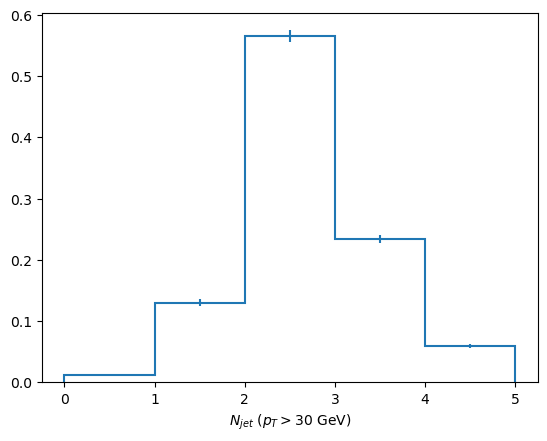

In [10]:
out_btag['EWK_ZZ2l2nu']['njets'][{'channel': 'catDY', 'systematic': 'nominal'}].plot(density=True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9d48de2280>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

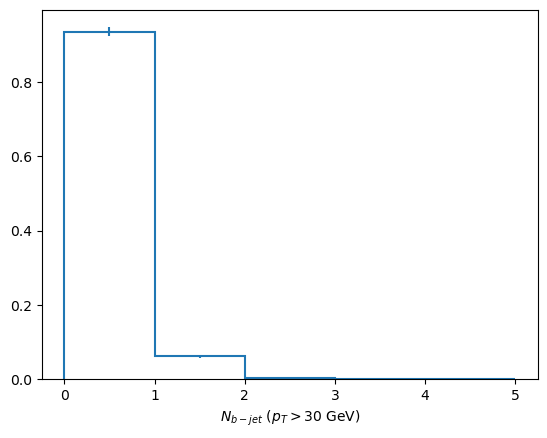

In [11]:
out_btag['EWK_ZZ2l2nu']['bjets'][{'channel': 'catDY', 'systematic': 'nominal'}].plot(density=True)

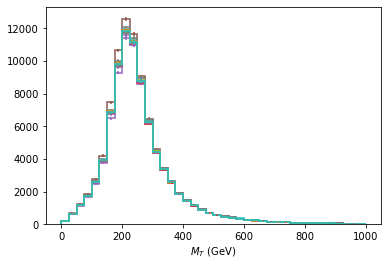

In [24]:
out_btag['ZZ2l2nu']['dilep_mt'][{'channel': 'catSR', 'systematic': 'nominal'}].plot()
for i in list(out_btag['ZZ2l2nu']['dilep_mt'].axes['systematic']):
    out_btag['ZZ2l2nu']['dilep_mt'][{'channel': 'catSR', 'systematic': i}].plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4433bb9610>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

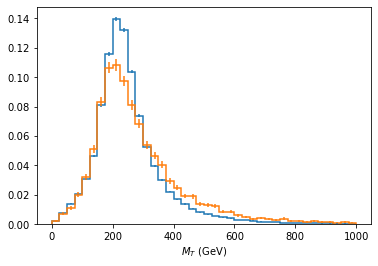

In [25]:
out_btag['ZZ2l2nu']['dilep_mt'][{'channel': 'catSR', 'systematic': 'nominal'}].plot(density=True)
out_btag['EWK_ZZ2l2nu']['dilep_mt'][{'channel': 'catSR', 'systematic': 'nominal'}].plot(density=True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4434095c10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

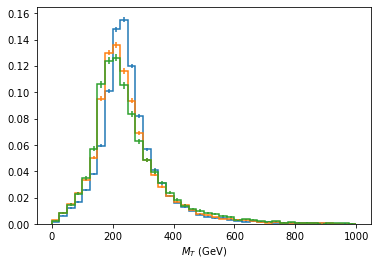

In [26]:
out_btag['ZZ2l2nu']['dilep_mt'][{'channel': 'catSR0', 'systematic': 'nominal'}].plot(density=True)
out_btag['ZZ2l2nu']['dilep_mt'][{'channel': 'catSR1', 'systematic': 'nominal'}].plot(density=True)
out_btag['ZZ2l2nu']['dilep_mt'][{'channel': 'catSR2', 'systematic': 'nominal'}].plot(density=True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f44338ecac0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

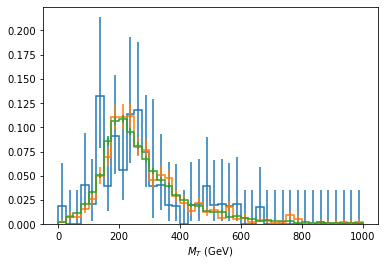

In [27]:
out_btag['EWK_ZZ2l2nu']['dilep_mt'][{'channel': 'catSR0', 'systematic': 'nominal'}].plot(density=True)
out_btag['EWK_ZZ2l2nu']['dilep_mt'][{'channel': 'catSR1', 'systematic': 'nominal'}].plot(density=True)
out_btag['EWK_ZZ2l2nu']['dilep_mt'][{'channel': 'catSR2', 'systematic': 'nominal'}].plot(density=True)